# –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–π –∫–æ–¥

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epo—Åhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epo—Åhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epo—Åhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epo—Åhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epo—Åhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epo—Åhs"]))
                    ax[2].set_xticklabels(np.arange(history["epo—Åhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
from torch import nn
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs ‚Äúmanually‚Äù
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

In [ ]:
activation_type = "sigmoid"
init_gain = torch.nn.init.calculate_gain(activation_type)


def init_weights(m):
    if isinstance(m, (nn.Linear,)):
        torch.nn.init.xavier_normal_(m.weight, gain=init_gain)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
import torch.nn as nn


class SimpleMNIST_NN(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid):
        super().__init__()
        self.n_layers = n_layers  # Num of layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]  # input layer
        for _ in range(n_layers - 1):  # append num of layers
            layers.append(nn.Linear(100, 100))
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))  # 10 classes
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # reshape to [-1, 784]
        x = self.layers(x)
        return x

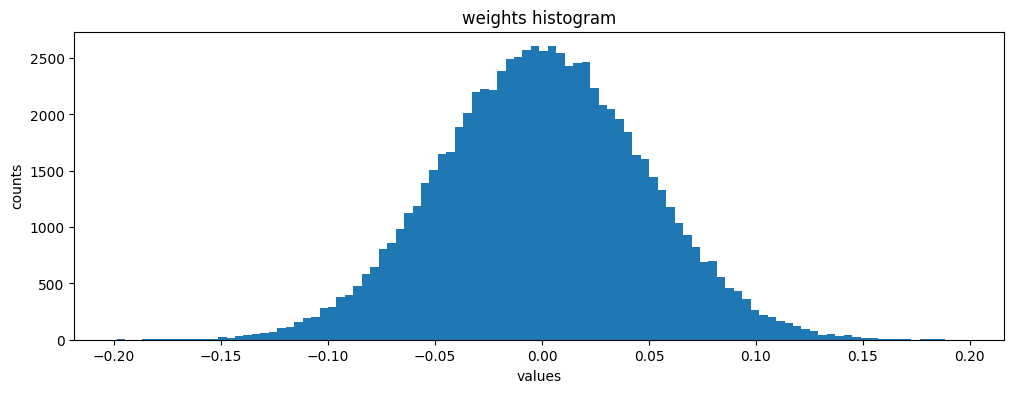

In [ ]:
model_name = "n3_layers_sigmoid_havier"
model = SimpleMNIST_NN(n_layers=3)
model.apply(init_weights)

# plotting weights values of first(input layer)
plt.figure(figsize=(12, 4))
plt.hist(
    list(model.layers.children())[0].weight.cpu().detach().numpy().reshape(-1), bins=100
)
plt.title("weights histogram")
plt.xlabel("values")
plt.ylabel("counts")
plt.show()

In [ ]:
from warnings import simplefilter
from lightning.pytorch.loggers import TensorBoardLogger

simplefilter("ignore", category=RuntimeWarning)


trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epo—Åhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# –†–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è

–í—Ç–æ—Ä–æ–π —Å–ø–æ—Å–æ–± —É–ª—É—á—à–µ–Ω–∏—è —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏ –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π –∏ –±–æ—Ä—å–±—ã —Å –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ–º ‚Äî –≤–≤–µ–¥–µ–Ω–∏–µ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏. –ï–µ –º–æ–∂–Ω–æ –≤–≤–æ–¥–∏—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–∏–º–∏ —Å–ø–æ—Å–æ–±–∞–º–∏.

## L1, L2 —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏

C–∞–º—ã–π –ø—Ä–æ—Å—Ç–æ–π —Å–ø–æ—Å–æ–± ‚Äî –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ —à—Ç—Ä–∞—Ñ–∞ –∫ –≤–µ—Å–∞–º –≤ —Ñ—É–Ω–∫—Ü–∏—é –ø–æ—Ç–µ—Ä—å. –ù–∞ —Å—Ö–æ–¥–∏–º–æ—Å—Ç—å –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ —ç—Ç–æ, –ø—Ä–∞–≤–¥–∞, –≤–ª–∏—è–µ—Ç —Å–ª–∞–±–æ.

$$ \text{Loss_reg} = \text{loss} + \lambda \cdot \text{reg}$$

$$ \text{reg}_{L1} = \lambda \sum |w_i| $$

$$ \text{reg}_{L2} = \lambda \sum w_i^2 $$

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/loss_landscape_with_regularization.gif" width="800"></center>

<center><em>Source: <a href="https://people.eecs.berkeley.edu/~jrs/189/">Introduction to Machine Learning
</a></em></center>


–ò–Ω–æ–≥–¥–∞ —É–∂–µ —ç—Ç–æ–≥–æ —Ö–≤–∞—Ç–∞–µ—Ç, —á—Ç–æ–±—ã —Ä–µ—à–∏—Ç—å –≤—Å–µ –ø—Ä–æ–±–ª–µ–º—ã. –ù–∞–ø–æ–º–Ω–∏–º, —á—Ç–æ **L2** Loss –ø—Ä–∏–≤–æ–¥–∏—Ç –∫ –±–æ–ª—å—à–æ–º—É —á–∏—Å–ª—É –º–∞–ª–µ–Ω—å–∫–∏—Ö –Ω–µ–Ω—É–ª–µ–≤—ã—Ö –≤–µ—Å–æ–≤ –≤ —Å–µ—Ç–∏, –∞ **L1** Loss ‚Äî –∫ –º–∞–ª–µ–Ω—å–∫–æ–º—É —á–∏—Å–ª—É –Ω–µ–Ω—É–ª–µ–≤—ã—Ö –≤–µ—Å–æ–≤ (—Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–æ–π –Ω–µ–π—Ä–æ—Å–µ—Ç–∏).

## Dropout

–û–¥–Ω–∏–º –∏–∑ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã—Ö –∏–º–µ–Ω–Ω–æ –≤ –Ω–µ–π—Ä–æ—Å–µ—Ç—è—Ö –º–µ—Ç–æ–¥–æ–º —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏ —è–≤–ª—è–µ—Ç—Å—è **Dropout**.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropout.png" width="700"></center>

–°–æ—Å—Ç–æ–∏—Ç —ç—Ç–æ—Ç –º–µ—Ç–æ–¥ –≤ —Å–ª–µ–¥—É—é—â–µ–º:

1. –í–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è –º—ã —Å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é $p$ **–∑–∞–Ω—É–ª—è–µ–º –≤—ã—Ö–æ–¥ –Ω–µ–π—Ä–æ–Ω–æ–≤** —Å–ª–æ—è (–Ω–∞–ø—Ä–∏–º–µ—Ä, $p = 0.5$).
2. –ó–∞–Ω—É–ª–µ–Ω–Ω—ã–µ –Ω–µ–π—Ä–æ–Ω—ã –Ω–µ —É—á–∞—Å—Ç–≤—É—é—Ç –≤ –¥–∞–Ω–Ω–æ–º `forward`, –∏ –ø–æ—ç—Ç–æ–º—É –≥—Ä–∞–¥–∏–µ–Ω—Ç –∫ –Ω–∏–º –ø—Ä–∏ `backward` –Ω–µ –∏–¥–µ—Ç.
3. –°–∏–ª–∞ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é $p$: —á–µ–º –æ–Ω–∞ –±–æ–ª—å—à–µ, —Ç–µ–º —Å–∏–ª—å–Ω–µ–µ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è.

### –ú–æ—Ç–∏–≤–∞—Ü–∏—è Dropout

#### –ë–æ—Ä—å–±–∞ —Å –∫–æ–∞–¥–∞–ø—Ç–∞—Ü–∏–µ–π

–û–¥–Ω–æ–π –∏–∑  –ø—Ä–æ–±–ª–µ–º –ø—Ä–∏ —Ä–∞–±–æ—Ç–µ —Å –≥–ª—É–±–æ–∫–∏–º–∏ —Å–µ—Ç—è–º–∏ —è–≤–ª—è–µ—Ç—Å—è **—Å–æ–≤–º–µ—Å—Ç–Ω–∞—è –∞–¥–∞–ø—Ç–∞—Ü–∏—è –Ω–µ–π—Ä–æ–Ω–æ–≤**. –ï—Å–ª–∏ –≤—Å–µ –≤–µ—Å–æ–≤—ã–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã –æ–±—É—á–∞—é—Ç—Å—è –≤–º–µ—Å—Ç–µ, –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ —Å–æ–µ–¥–∏–Ω–µ–Ω–∏—è –±—É–¥—É—Ç –∏–º–µ—Ç—å –±–æ–ª—å—à–µ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–µ–π –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è, —á–µ–º –¥—Ä—É–≥–∏–µ.

**–ß–∞—Å—Ç—å –Ω–µ–π—Ä–æ–Ω–æ–≤** –¥–µ–ª–∞–µ—Ç –æ—Å–Ω–æ–≤–Ω—É—é —Ä–∞–±–æ—Ç—É ‚Äî **–ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç**, –∞ –æ—Å—Ç–∞–ª—å–Ω—ã–µ –º–æ–≥—É—Ç –≤–æ–æ–±—â–µ –Ω–µ –≤–Ω–æ—Å–∏—Ç—å –Ω–∏–∫–∞–∫–æ–≥–æ –≤–∫–ª–∞–¥–∞ –≤ –∏—Ç–æ–≥–æ–≤–æ–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ. –ò–ª–∏ –∂–µ –¥—Ä—É–≥–∞—è –∫–∞—Ä—Ç–∏–Ω–∞: –æ–¥–∏–Ω –Ω–µ–π—Ä–æ–Ω –¥–µ–ª–∞–µ—Ç **–Ω–µ–≤–µ—Ä–Ω–æ–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ**, –¥—Ä—É–≥–∏–µ –µ–≥–æ **–∏—Å–ø—Ä–∞–≤–ª—è—é—Ç**, –∏ –≤ –∏—Ç–æ–≥–µ –ø–µ—Ä–≤—ã–π –Ω–µ–π—Ä–æ–Ω —Å–≤–æ–∏ –æ—à–∏–±–∫–∏ –Ω–µ –∏—Å–ø—Ä–∞–≤–ª—è–µ—Ç.

–ú–æ–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –ø–æ–Ω—è—Ç—å, –∫–∞–∫ —ç—Ç–æ —Ä–∞–±–æ—Ç–∞–µ—Ç, —á–µ—Ä–µ–∑ –∞–Ω–∞–ª–æ–≥–∏—é ‚Äî –∫–æ–Ω–≤–µ–π–µ—Ä –ø–æ —Å–±–æ—Ä–∫–µ –º–∞—à–∏–Ω—ã: –æ—Å–Ω–æ–≤–Ω—É—é —á–∞—Å—Ç—å —Ä–∞–±–æ—Ç—ã –º–æ–∂–µ—Ç –∏—Å–ø–æ–ª–Ω—è—Ç—å –Ω–µ–±–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç–Ω–∏–∫–æ–≤. –î—Ä—É–≥–∏–µ —Ä–∞–±–æ—Ç–Ω–∏–∫–∏ –º–æ–≥—É—Ç –ª–µ–Ω–∏—Ç—å—Å—è –∏ –ø–µ—Ä–µ–¥–∞–≤–∞—Ç—å –¥–µ—Ç–∞–ª—å, –∫–æ—Ç–æ—Ä–∞—è –∫ –Ω–∏–º –ø–æ—Å—Ç—É–ø–∏–ª–∞, –±–µ–∑ –∏–∑–º–µ–Ω–µ–Ω–∏–π –∏–ª–∏ –æ—Ç–∫—Ä—É—á–∏–≤–∞—Ç—å —Ç–æ–ª—å–∫–æ —á—Ç–æ –¥–æ–±–∞–≤–ª–µ–Ω–Ω—ã–µ —á–∞—Å—Ç–∏. –ï—Å–ª–∏ –º—ã –∏—Å–∫–ª—é—á–∏–º —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã—Ö —Ä–∞–±–æ—Ç–Ω–∏–∫–æ–≤, —Ä–µ–∑—É–ª—å—Ç–∞—Ç —Å—Ç–∞–Ω–µ—Ç —É–¥—Ä—É—á–∞—é—â–∏–º.

–≠—Ç–æ —è–≤–ª–µ–Ω–∏–µ –Ω–∞–∑—ã–≤–∞–µ—Ç—Å—è **–∫–æ–∞–¥–∞–ø—Ç–∞—Ü–∏–µ–π**. –ï–≥–æ –Ω–µ–ª—å–∑—è –±—ã–ª–æ –ø—Ä–µ–¥–æ—Ç–≤—Ä–∞—Ç–∏—Ç—å —Å –ø–æ–º–æ—â—å—é —Ç—Ä–∞–¥–∏—Ü–∏–æ–Ω–Ω–æ–π —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏, —Ç–∞–∫–æ–π –∫–∞–∫ **L1** –∏–ª–∏ **L2**. –ê –≤–æ—Ç **Dropout** —Å —ç—Ç–∏–º —Ö–æ—Ä–æ—à–æ –±–æ—Ä–µ—Ç—Å—è.

–û—Ç–∫–ª—é—á–∞—è —Ö–æ—Ä–æ—à–æ –æ–±—É—á–µ–Ω–Ω—ã–µ –Ω–µ–π—Ä–æ–Ω—ã, –º—ã –∑–∞—Å—Ç–∞–≤–ª—è–µ–º –ø–ª–æ—Ö–æ –æ–±—É—á–µ–Ω–Ω—ã–µ –Ω–µ–π—Ä–æ–Ω—ã —É—á–∏—Ç—å—Å—è.

–û—Ç–∫–ª—é—á–∞—è –Ω–µ–π—Ä–æ–Ω—ã, –∫–æ—Ç–æ—Ä—ã–µ –∏—Å–ø—Ä–∞–≤–ª—è—é—Ç –æ—à–∏–±–∫–∏ –¥—Ä—É–≥–∏—Ö –Ω–µ–π—Ä–æ–Ω–æ–≤, –º—ã –∑–∞—Å—Ç–∞–≤–ª—è–µ–º –æ—à–∏–±–∞—é—â–∏–µ—Å—è –Ω–µ–π—Ä–æ–Ω—ã –∏—Å–ø—Ä–∞–≤–ª—è—Ç—å –æ—à–∏–±–∫–∏.

–ù–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ –Ω–∏–∂–µ –∏–∑ [—Å—Ç–∞—Ç—å–∏ –ø—Ä–æ Dropout üéì[article]](https://jmlr.org/papers/v15/srivastava14a.html), —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ –∫–∞—Ä—Ç –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –¥–∞—Ç–∞—Å–µ—Ç–∞ **MNIST**. –°–ª–µ–≤–∞ –Ω–µ–π—Ä–æ—Å–µ—Ç—å **–±–µ–∑ Dropout** , —Å–ø—Ä–∞–≤–∞ –Ω–µ–π—Ä–æ—Å–µ—Ç—å —Å —Ç–∞–∫–æ–π –∂–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–æ–π —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º **Dropout**  ($p = 0.5$).

–°–ª–µ–≤–∞ –Ω–µ—Å—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ, –±–µ—Å–ø–æ—Ä—è–¥–æ—á–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ–≤–æ–∑–º–æ–∂–Ω–æ –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä–æ–≤–∞—Ç—å. –°–ø—Ä–∞–≤–∞ —è–≤–Ω–æ –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É–µ—Ç—Å—è —Ü–µ–ª–µ–Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–µ—Å–æ–≤, –∫–æ—Ç–æ—Ä–æ–µ –æ–±–Ω–∞—Ä—É–∂–∏–≤–∞–µ—Ç —à—Ç—Ä–∏—Ö–∏, –∫—Ä–∞—è –∏ –ø—è—Ç–Ω–∞ —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–æ, –Ω–∞—Ä—É—à–∞—è –∏—Ö –≤–∑–∞–∏–º–æ–∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å —Å –¥—Ä—É–≥–∏–º–∏ –Ω–µ–π—Ä–æ–Ω–∞–º–∏ –¥–ª—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —ç—Ç–æ–π —Ä–∞–±–æ—Ç—ã.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/compare_weights_with_dropout_and_without_dropout.png" width="600"></center>

<center><em>Source: <a href="https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">Dropout: A Simple Way to Prevent Neural Networks from
Overfitting</a></em></center>

#### Dropout –∫–∞–∫ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è

–§–∞–∫—Ç–∏—á–µ—Å–∫–∏ **Dropout** —à—Ç—Ä–∞—Ñ—É–µ—Ç —Å–ª–∏—à–∫–æ–º —Å–ª–æ–∂–Ω—ã–µ, –Ω–µ—É—Å—Ç–æ–π—á–∏–≤—ã–µ —Ä–µ—à–µ–Ω–∏—è. –î–æ–±–∞–≤–ª—è—è –≤ –Ω–µ–π—Ä–æ—Å–µ—Ç—å **Dropout**, –º—ã —Å–æ–æ–±—â–∞–µ–º –µ–π, —á—Ç–æ —Ä–µ—à–µ–Ω–∏–µ, –∫–æ—Ç–æ—Ä–æ–µ –º—ã –æ–∂–∏–¥–∞–µ–º, –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å —É—Å—Ç–æ–π—á–∏–≤–æ –∫ —à—É–º—É.

#### Dropout –∫–∞–∫ –∞–Ω—Å–∞–º–±–ª—å

–ú–æ–∂–Ω–æ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞—Ç—å **Dropout** –∫–∞–∫ **–∞–Ω—Å–∞–º–±–ª—å –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π** —Å–æ —Å—Ö–æ–∂–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏, –∫–æ—Ç–æ—Ä—ã–µ –º—ã —É—á–∏–º –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ –≤–º–µ—Å—Ç–æ —Ç–æ–≥–æ, —á—Ç–æ–±—ã —É—á–∏—Ç—å –∫–∞–∂–¥—É—é –≤ –æ—Ç–¥–µ–ª—å–Ω–æ—Å—Ç–∏, –∞ –∑–∞—Ç–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç –∏—Ö –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —É—Å—Ä–µ–¥–Ω—è–µ–º, [–≤—ã–∫–ª—é—á–∞—è Dropout –≤ —Ä–µ–∂–∏–º–µ eval ‚úèÔ∏è[blog]](https://habr.com/ru/companies/wunderfund/articles/330814/).

–¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º –≤–æ–∑–Ω–∏–∫–∞–µ—Ç –∞–Ω–∞–ª–æ–≥–∏—è —Å–æ —Å–ª—É—á–∞–π–Ω—ã–º –ª–µ—Å–æ–º: –∫–∞–∂–¥–∞—è –∏–∑ –Ω–∞—à–∏—Ö –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π –ª–µ–≥–∫–æ –≤—ã—É—á–∏–≤–∞–µ—Ç –≤—ã–±–æ—Ä–∫—É –∏ –ø–µ—Ä–µ–æ–±—É—á–∞–µ—Ç—Å—è ‚Äî –∏–º–µ–µ—Ç –Ω–∏–∑–∫–∏–π bias, –Ω–æ –≤—ã—Å–æ–∫–∏–π variance. –ü—Ä–∏ —ç—Ç–æ–º, –∑–∞ —Å—á–µ—Ç –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ –æ—Ç–∫–ª—é—á–µ–Ω–∏—è –∞–∫—Ç–∏–≤–∞—Ü–∏–π, –∫–∞–∂–¥–∞—è –Ω–µ–π—Ä–æ—Å–µ—Ç—å –≤–∏–¥–∏—Ç –Ω–µ –≤—Å–µ –æ–±—ä–µ–∫—Ç—ã, –∞ —Ç–æ–ª—å–∫–æ —á–∞—Å—Ç—å. –£—Å—Ä–µ–¥–Ω—è—è –≤—Å–µ —ç—Ç–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è, –º—ã —É–º–µ–Ω—å—à–∞–µ–º variance.

#### Dropout –ø–æ–º–æ–≥–∞–µ—Ç –±–æ—Ä–æ—Ç—å—Å—è —Å –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ–º

Dropout, –≤ —Å–∏–ª—É —É–∫–∞–∑–∞–Ω–Ω–æ–≥–æ –≤—ã—à–µ, –º–æ–∂–µ—Ç —Ö–æ—Ä–æ—à–æ –ø–æ–º–æ–≥–∞—Ç—å –±–æ—Ä–æ—Ç—å—Å—è —Å –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ–º.



<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/dropout_solve_overfitting_problem_in_mlp_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em></center>

#### –ü—Ä–æ—Å—Ç–∞—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è Dropout

–ù–∞–ø–∏—à–µ–º "–Ω–∞–∏–≤–Ω—É—é" —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é –º–æ–¥—É–ª—è Dropout.

**–ó–∞–º–µ—á–∞–Ω–∏–µ:** —ç—Ç–æ—Ç –±–ª–æ–∫ –∫–æ–¥–∞ –¥–∞–Ω –¥–ª—è –æ–±—ä—è—Å–Ω–µ–Ω–∏—è —Ä–∞–±–æ—Ç—ã Dropout. –ü—Ä–∏ –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏–∏ –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏ –∏—Å–ø–æ–ª—å–∑—É–π—Ç–µ `nn.Dropout` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) –∏–ª–∏ `nn.Dropout2d` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

```python
class BadDropout(nn.Module):
    def __init__(self, p: float=0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(device)
            return x * keep
        # In test time, expectation is calculated
        return x * (1 - self.p)
```



–ü—Ä–∏–≤–µ–¥–µ–Ω–Ω–∞—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è –Ω–µ–æ–ø—Ç–∏–º–∞–ª—å–Ω–∞, —Ç–∞–∫ –∫–∞–∫ –≤ —Ä–µ–∂–∏–º–µ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞ (–∫–æ–≥–¥–∞ `training = False`) —Ñ—É–Ω–∫—Ü–∏—è `forward` —Å–æ–≤–µ—Ä—à–∞–µ—Ç –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–µ —É–º–Ω–æ–∂–µ–Ω–∏–µ. –û–¥–Ω–∏–º –∏–∑ –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç–æ–≤ –ø—Ä–∏ —Å–æ–∑–¥–∞–Ω–∏–∏ –º–æ–¥–µ–ª–∏ —è–≤–ª—è–µ—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å —Ä–∞–±–æ—Ç—ã –≤ —Ä–µ–∂–∏–º–µ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞. –ü–æ—ç—Ç–æ–º—É –ø–æ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏ –≤—Å–µ "–ª–∏—à–Ω–∏–µ" –æ–ø–µ—Ä–∞—Ü–∏–∏ –≤—ã–ø–æ–ª–Ω—è—é—Ç —Ç–æ–ª—å–∫–æ –≤ —Ä–µ–∂–∏–º–µ –æ–±—É—á–µ–Ω–∏—è. –í –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ –º–æ–∂–Ω–æ —Ü–µ–ª–∏–∫–æ–º —É–±—Ä–∞—Ç—å –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –Ω–æ—Ä–º–∏—Ä–æ–≤–∫–∏ –∏–∑ —Ä–µ–∂–∏–º–∞ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞, –ø–µ—Ä–µ–Ω–µ—Å—è –µ–≥–æ –≤ —Ä–µ–∂–∏–º –æ–±—É—á–µ–Ω–∏—è –≤ –∑–Ω–∞–º–µ–Ω–∞—Ç–µ–ª—å.

–î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–º –ø–ª—é—Å–æ–º —Ç–∞–∫–æ–≥–æ –ø–æ–¥—Ö–æ–¥–∞ —è–≤–ª—è–µ—Ç—Å—è —Ç–æ, —á—Ç–æ –ø—Ä–∏ —É–¥–∞–ª–µ–Ω–∏–∏ –º–æ–¥—É–ª—è –∏–∑ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã —Å–µ—Ç–∏ —Ñ—É–Ω–∫—Ü–∏—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è –Ω–µ –∏–∑–º–µ–Ω–∏—Ç—Å—è.


```python
class Dropout(nn.Module):
    def __init__(self, p: float=0.2):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(x)
            return x * keep / (1 - self.p)
        return x  # in test time, expectation is calculated intrinsically - we just not divide weights
```



–ü–æ–ø—Ä–æ–±—É–µ–º –ø—Ä–∏–º–µ–Ω–∏—Ç—å Dropout –≤ –Ω–∞—à–µ–π –Ω–µ–π—Ä–æ—Å–µ—Ç–∏:

In [ ]:
class SimpleMNIST_NN_Dropout(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid, init_form="normal"):
        super().__init__()
        self.n_layers = n_layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100))
            layers.append(nn.Dropout(p=0.2))  # add Dropout
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

–¢–∞–∫ –∫–∞–∫ –Ω–∞—à–∞ –º–æ–¥–µ–ª—å –∏–∑-–∑–∞ Dropout –≤–µ–¥–µ—Ç —Å–µ–±—è –ø–æ-—Ä–∞–∑–Ω–æ–º—É –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è –∏ –≤–æ –≤—Ä–µ–º—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è, –º—ã –¥–æ–ª–∂–Ω—ã –ø—Ä—è–º–æ –µ–π —Å–æ–æ–±—â–∞—Ç—å, –æ–±—É—á–∞–µ—Ç—Å—è –æ–Ω–∞ —Å–µ–π—á–∞—Å –∏–ª–∏ –Ω–µ—Ç.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{–ê–∫—Ç–∏–≤–∏—Ä—É—é—Ç—Å—è Dropout —Å–ª–æ–∏}}&\large{\text{–°–ª–æ–∏ Dropout –æ—Ç–∫–ª—é—á–µ–Ω—ã}}\\
\large{\text{–í—ã—Ö–æ–¥ —á–∞—Å—Ç–∏ –Ω–µ–π—Ä–æ–Ω–æ–≤ –æ–±–Ω—É–ª—è–µ—Ç—Å—è, –≤—ã—Ö–æ–¥—ã –Ω–æ—Ä–º–∏—Ä—É—é—Ç—Å—è}}&\large{\text{–í—Å–µ –Ω–µ–π—Ä–æ–Ω—ã —Ä–∞–±–æ—Ç–∞—é—Ç}}
\end{array}
$$



In [ ]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(3072, 500),
    nn.Dropout(p=0.2),
    nn.Linear(500, 1),
    )

model.train()
dummy = torch.randn((1, 3072)) # batch, features
print("Train:")
for i in range(5):
  print(f"\t{model(dummy).item():.4f}")

print("Inference:")
model.eval()
for i in range(5):
  print(f"\t{model(dummy).item():.4f}")


Train:
	0.2007
	-0.1262
	0.0913
	0.2597
	-0.0313
Inference:
	0.2521
	0.2521
	0.2521
	0.2521
	0.2521


–û–±—É—á–∏–º –º–æ–¥–µ–ª—å —Å **Dropout**:

In [ ]:
model_name = "nn3_dropout"
model = SimpleMNIST_NN_Dropout(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epo—Åhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Dropout | 99.7 K | train
1 | criterion | CrossEntropyLoss       | 0      | train
-------------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mod

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


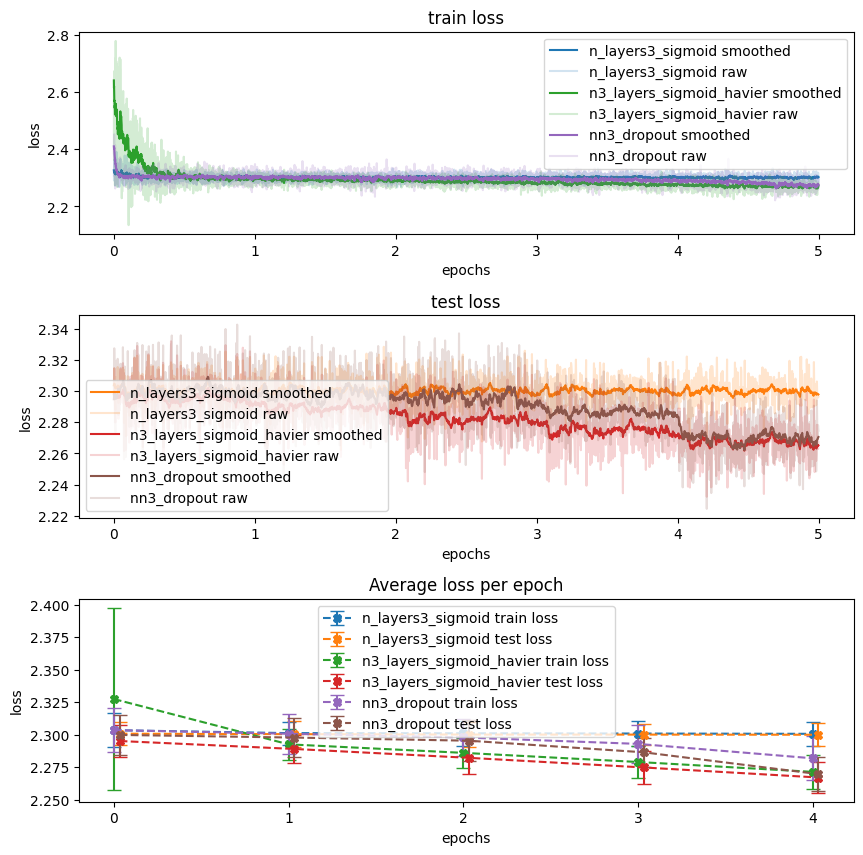

In [ ]:
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

–í –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ –≤—ã–∏–≥—Ä—ã—à –Ω–µ–±–æ–ª—å—à–æ–π. –ï—Å–ª–∏ —É—á–∏—Ç—å –Ω–µ–π—Ä–æ—Å–µ—Ç—å –±–æ–ª—å—à–µ —ç–ø–æ—Ö, —ç—Ñ—Ñ–µ–∫—Ç –±—É–¥–µ—Ç –∑–∞–º–µ—Ç–Ω–µ–µ.

#### –ü—Ä–∏–º–µ—Ä –±–æ—Ä—å–±—ã —Å –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ–º –ø—Ä–∏ –ø–æ–º–æ—â–∏ Dropout


–ß—Ç–æ–±—ã —É–≤–∏–¥–µ—Ç—å —ç—Ñ—Ñ–µ–∫—Ç –∏ –ø—Ä–∏ —ç—Ç–æ–º –Ω–µ —É—á–∏—Ç—å –Ω–µ–π—Ä–æ—Å–µ—Ç—å 100+ —ç–ø–æ—Ö, —Å–¥–µ–ª–∞–µ–º –∏—Å–∫—É—Å—Å—Ç–≤–µ–Ω–Ω—ã–π –ø—Ä–∏–º–µ—Ä.

–ü—Ä–æ—Å—Ç–æ **–¥–æ–±–∞–≤–∏–º –∫ –ª–∏–Ω–µ–π–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ —à—É–º** –∏ –ø–æ–ø—Ä–æ–±—É–µ–º –≤—ã—É—á–∏—Ç—å –µ–µ –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç—å—é.

[[colab] ü•® Batch Normalization and Dropout](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/7_BatchNormalization/BatchNorm_Dropout.ipynb)

In [ ]:
N = 50  # number of data points
noise = 0.3

# Generate the train data
x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

# Generate the test data
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

print(f"x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}")

x_train shape: torch.Size([50, 1])
x_test shape: torch.Size([50, 1])


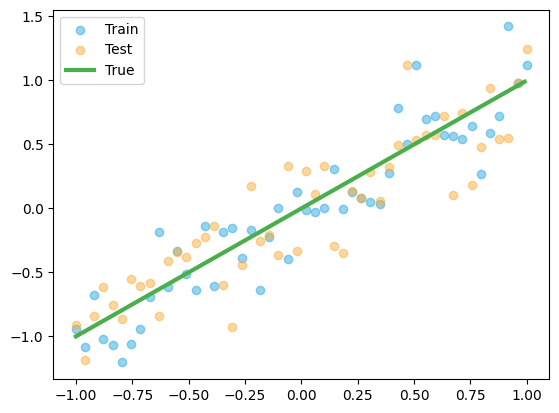

In [ ]:
plt.scatter(
    x_train.data.numpy(), y_train.data.numpy(), c="#2DA9E1", alpha=0.5, label="Train"
)
plt.scatter(
    x_test.data.numpy(), y_test.data.numpy(), c="#F9B041", alpha=0.5, label="Test"
)

x_real = np.arange(-1, 1, 0.01)
y_real = x_real
plt.plot(x_real, y_real, c="#4AAE4D", label="True", linewidth=3)
plt.legend()
plt.show()

–ú–æ–¥–µ–ª—å **–±–µ–∑ Dropout**:

In [ ]:
N_h = 100  # num of neurons
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

–ú–æ–¥–µ–ª—å **—Å Dropout**:

In [ ]:
N_h = 100  # num of neurons

model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.5),  # 50 % probability
    nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    nn.Dropout(0.2),  # 20% probability
    nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)

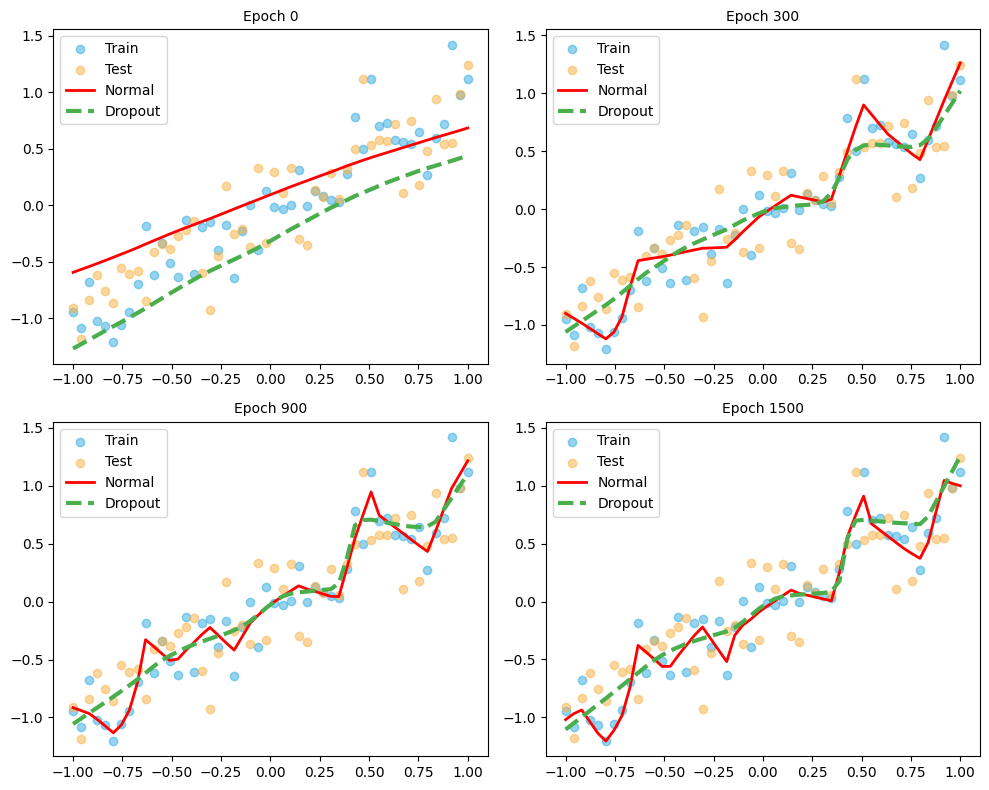

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
plot_epochs = [0, 300, 900, 1500]

num_epochs = 1501
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_dropout = model_dropout(x_train)
    loss_dropout = criterion(y_pred_dropout, y_train)
    optimizer_dropout.zero_grad()
    loss_dropout.backward()
    optimizer_dropout.step()

    if epoch in plot_epochs:
        model.eval()
        model_dropout.eval()

        y_test_pred = model(x_test)
        test_loss = criterion(y_test_pred, y_test)

        y_test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = criterion(y_test_pred_dropout, y_test)

        ax = axes[plot_epochs.index(epoch)]
        ax.scatter(
            x_train.data.numpy(),
            y_train.data.numpy(),
            alpha=0.5,
            c="#2DA9E1",
            label="Train",
        )
        ax.scatter(
            x_test.data.numpy(),
            y_test.data.numpy(),
            c="#F9B041",
            alpha=0.5,
            label="Test",
        )
        ax.plot(
            x_test.data.numpy(), y_test_pred.data.numpy(), "r-", lw=2, label="Normal"
        )
        ax.plot(
            x_test.data.numpy(),
            y_test_pred_dropout.data.numpy(),
            "#4AAE4D", linestyle='dashed',
            lw=3,
            label="Dropout",
        )

        ax.set_title(
            f"Epoch {epoch}",
            fontsize=10,
        )
        ax.legend()
        model.train()
        model_dropout.train()
plt.tight_layout()
plt.show()


–í–∏–¥–∏–º, —á—Ç–æ **–Ω–µ–π—Ä–æ—Å–µ—Ç—å –±–µ–∑ Dropout —Å–∏–ª—å–Ω–æ –ø–µ—Ä–µ–æ–±—É—á–∏–ª–∞—Å—å**.

#### –î–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª –æ—Ç Dropout

Dropout –º–æ–∂–Ω–æ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞—Ç—å –∫–∞–∫ **–∞–Ω—Å–∞–º–±–ª—å –º–æ–¥–µ–ª–µ–π**.

–ï—Å–ª–∏ –º—ã –≤–æ–∑—å–º–µ–º –æ–¥–∏–Ω –∏ —Ç–æ—Ç –∂–µ –æ–±—ä–µ–∫—Ç –∏ –ø—Ä–æ–ø—É—Å—Ç–∏–º –µ–≥–æ —á–µ—Ä–µ–∑ –º–æ–¥–µ–ª—å —Å **–∞–∫—Ç–∏–≤–Ω—ã–º Dropout 1000 —Ä–∞–∑**, —ç—Ç–æ –±—É–¥–µ—Ç —ç–∫–≤–∏–≤–∞–ª–µ–Ω—Ç–Ω–æ —Ç–æ–º—É, —á—Ç–æ–±—ã –ø—Ä–æ–ø—É—Å—Ç–∏—Ç—å —ç—Ç–æ—Ç –æ–±—ä–µ–∫—Ç —á–µ—Ä–µ–∑ **1000 –º–æ–¥–µ–ª–µ–π —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è–º–∏**. –¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º –º—ã –ø–æ–ª—É—á–∏–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π, –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–æ—Ç–æ—Ä–æ–≥–æ –º–æ–∂–Ω–æ –≤—ã—á–∏—Å–ª—è—Ç—å [**–¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–µ –∏–Ω—Ç–µ—Ä–≤–∞–ª—ã** üìö[wiki]](https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%B2%D0%B5%D1%80%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B2%D0%B0%D0%BB) –∏ –ª–æ–≤–∏—Ç—å –∞–Ω–æ–º–∞–ª–∏–∏ (–æ–±—ä–µ–∫—Ç—ã —Å –±–æ–ª—å—à–æ–π –¥–∏—Å–ø–µ—Ä—Å–∏–µ–π –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ–º—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π, –∫–æ—Ç–æ—Ä—ã–µ –ø–ª–æ—Ö–æ —Ä–∞—Å–ø–æ–∑–Ω–∞—é—Ç—Å—è —Å–µ—Ç—å—é).

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/confidence_interval_dropout.png" width="600"></center>

<center><em>Source: <a href="https://atcold.github.io/NYU-DLSP20/en/week14/14-3/">Overfitting and regularization</a></em></center>



## DropConnect

–ï—Å–ª–∏ –∑–∞–Ω—É–ª—è—Ç—å –Ω–µ –Ω–µ–π—Ä–æ–Ω—ã (–∞–∫—Ç–∏–≤–∞—Ü–∏–∏), –∞ —Å–ª—É—á–∞–π–Ω—ã–µ –≤–µ—Å–∞ —Å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é $p$, –ø–æ–ª—É—á–∏—Ç—Å—è DropConnect.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropconnect.png" width="650"></center>

DropConnect –ø–æ—Ö–æ–∂ –Ω–∞ Dropout, –ø–æ—Å–∫–æ–ª—å–∫—É –æ–Ω –≤–≤–æ–¥–∏—Ç –¥–∏–Ω–∞–º–∏—á–µ—Å–∫—É—é —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–æ—Å—Ç—å –≤ –º–æ–¥–µ–ª—å, –Ω–æ –æ—Ç–ª–∏—á–∞–µ—Ç—Å—è —Ç–µ–º, —á—Ç–æ —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–æ—Å—Ç—å –∑–∞–≤–∏—Å–∏—Ç –æ—Ç –≤–µ—Å–æ–≤ *W*, –∞ –Ω–µ –æ—Ç –≤—ã—Ö–æ–¥–Ω—ã—Ö –≤–µ–∫—Ç–æ—Ä–æ–≤ —Å–ª–æ—è. –î—Ä—É–≥–∏–º–∏ —Å–ª–æ–≤–∞–º–∏, –ø–æ–ª–Ω–æ—Å—Ç—å—é —Å–≤—è–∑–∞–Ω–Ω—ã–π —Å–ª–æ–π —Å DropConnect —Å—Ç–∞–Ω–æ–≤–∏—Ç—Å—è —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–æ —Å–≤—è–∑–∞–Ω–Ω—ã–º —Å–ª–æ–µ–º, –≤ –∫–æ—Ç–æ—Ä–æ–º —Å–æ–µ–¥–∏–Ω–µ–Ω–∏—è –≤—ã–±–∏—Ä–∞—é—Ç—Å—è —Å–ª—É—á–∞–π–Ω—ã–º –æ–±—Ä–∞–∑–æ–º –Ω–∞ —ç—Ç–∞–ø–µ –æ–±—É—á–µ–Ω–∏—è.

–í –ø—Ä–∏–Ω—Ü–∏–ø–µ, –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –∑–∞–Ω—É–ª–µ–Ω–∏—è —á–µ–≥–æ-—Ç–æ –≤ –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏ –º–æ–∂–Ω–æ –ø—Ä–µ–¥–ª–æ–∂–∏—Ç—å –≤–µ–ª–∏–∫–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ, –≤ —Ä–∞–∑–Ω—ã—Ö —Å–∏—Ç—É–∞—Ü–∏—è—Ö –±—É–¥—É—Ç —Ä–∞–±–æ—Ç–∞—Ç—å —Ä–∞–∑–Ω—ã–µ —Å–ø–æ—Å–æ–±—ã ([–≤ —ç—Ç–æ–º —Å–ø–∏—Å–∫–µ üéì[article]](https://paperswithcode.com/methods/category/regularization) –º–Ω–æ–≥–æ Drop...).

## DropBlock

–ù–∞–ø—Ä–∏–º–µ—Ä, –º–æ–∂–Ω–æ —É–±–∏—Ä–∞—Ç—å –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –±–∞—Ç—á–∞ –∏–∑ –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ —Å–ª—É—á–∞–π–Ω—ã–µ –±–ª–æ–∫–∏ –∏–∑ —Å–ª–æ–µ–≤. –ò —ç—Ç–æ –±—É–¥–µ—Ç —Ä–∞–±–æ—Ç–∞—Ç—å!

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropblock.png" width="750"></center>

[[arxiv] üéì Deep Networks with Stochastic Depth (Huang et al., 2016)](https://arxiv.org/pdf/1603.09382.pdf)

## –°–æ–≤–µ—Ç—ã –ø–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—é Dropout

–ù–∞–∏–±–æ–ª–µ–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ —Ä–∞–∑–º–µ—â–∞—Ç—å Dropout –¥–ª—è –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã—Ö (fully connected) —Å–ª–æ–µ–≤, –≤ –∫–æ–Ω—Ü–µ —Å–µ—Ç–∏.




### Batch Normalization –¥–æ –∏–ª–∏ –ø–æ—Å–ª–µ Dropout



#### –ü–æ—Å–ª–µ

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_after_dropout.png" width="400"></center>

* **–ü–ª–æ—Ö–æ**: –í —Ä–µ–∂–∏–º–µ –æ–±—É—á–µ–Ω–∏—è **Dropout** –±—É–¥–µ—Ç –æ—Ç–∫–ª—é—á–∞—Ç—å (–∑–∞–Ω—É–ª—è—Ç—å) –≤—ã—Ö–æ–¥—ã —Å–ª–æ—è –∞–∫—Ç–∏–≤–∞—Ü–∏–∏, –∏–∑-–∑–∞ —ç—Ç–æ–≥–æ –Ω–∞–∫–æ–ø–ª–µ–Ω–Ω—ã–µ –≤ —Ä–µ–∂–∏–º–µ –æ–±—É—á–µ–Ω–∏—è **–∑–Ω–∞—á–µ–Ω–∏—è —Å–∫–æ–ª—å–∑—è—â–µ–≥–æ —Å—Ä–µ–¥–Ω–µ–≥–æ –º–∞—Ç–æ–∂–∏–¥–∞–Ω–∏—è –∏ –¥–∏—Å–ø–µ—Ä—Å–∏–∏** –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è **Batch Normalization** –≤ —Ä–µ–∂–∏–º–µ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –±—É–¥—É—Ç –∏–º–µ—Ç—å **—Å–¥–≤–∏–≥** (–Ω–µ –∫–æ–º–ø–µ–Ω—Å–∏—Ä—É–µ–º—ã–π –ø—Ä–∏–≤–µ–¥–µ–Ω–∏–µ–º —Å–ª–æ—è Dropout –≤ —Ä–µ–∂–∏–º `train()`), –∫–æ—Ç–æ—Ä—ã–π –ø—Ä–∏–≤–µ–¥–µ—Ç –∫ –Ω–µ—Å—Ç–∞–±–∏–ª—å–Ω–æ–π —Ä–∞–±–æ—Ç–µ –Ω–µ–π—Ä–æ—Å–µ—Ç–∏.


–ü–æ–¥—Ä–æ–±–Ω–æ:
* [[arxiv] üéì Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift (Li et al., 2018)](https://arxiv.org/pdf/1801.05134.pdf)
* [[git] üêæ Understanding the Disharmony between Dropout and Batch Normalization](https://github.com/adelizer/kaggle-sandbox/blob/master/drafts/dropout_bn.ipynb)

#### –î–æ

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_before_dropout.png" width="400"></center>

* **–õ—É—á—à–µ**: –ú–µ–Ω—å—à–µ –≤–ª–∏—è–Ω–∏–µ —Å–¥–≤–∏–≥–∞ –æ—Ç **Dropout** –Ω–∞ **Batch Norm**. –ù–æ –µ—Å–ª–∏ –Ω–∞ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö —Å–ª–æ—è—Ö –µ—Å—Ç—å **Dropout**, —Ç–æ –∑–Ω–∞—á–µ–Ω–∏—è –≤—Å–µ —Ä–∞–≤–Ω–æ –º–æ–≥—É—Ç –±—ã—Ç—å —Å–º–µ—â–µ–Ω—ã.

#### –°—Ç–∞–≤–∏—Ç—å —Ç–æ–ª—å–∫–æ —á—Ç–æ-—Ç–æ –æ–¥–Ω–æ

* **Dropout** –º–æ–∂–µ—Ç –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–æ –≤–ª–∏—è—Ç—å –Ω–∞ –∫–∞—á–µ—Å—Ç–≤–æ –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ —Å **Batch Norm** –∑–∞ —Å—á–µ—Ç —Ä–∞–∑–Ω–æ–≥–æ –ø–æ–≤–µ–¥–µ–Ω–∏—è –Ω–∞ train –∏ test. –ü–æ—ç—Ç–æ–º—É –ª—É—á—à–µ –Ω–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Å–≤—è–∑–∫—É **Dropout** + **Batch Norm** –∏ —Å—Ç–∞–≤–∏—Ç—å —ç—Ç–∏ —Å–ª–æ–∏ –≤ —Ä–∞–∑–Ω—ã–µ —á–∞—Å—Ç–∏ —Å–µ—Ç–∏. **Batch Norm** –ø–æ—Å–ª–µ —Å–≤–µ—Ä—Ç–æ—á–Ω—ã—Ö —Å–ª–æ–µ–≤, **Dropout** –≤ –∫–æ–Ω—Ü–µ —Å–µ—Ç–∏ –Ω–∞ –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–ª–æ–∏.